### Use Python XGBoost and Optuna hyper parameter tuning to build model and deploy with KNIME Python nodes


<img src="../KNIME_loves_xgboost_optuna.png" width="600">


##### KNIME workflow
https://hub.knime.com/-/spaces/-/latest/~GABT_OgeoWxWJW9P/


##### GitHub: A small collection of Jupyter Notebooks to solve CLASSIFICATION tasks

https://github.com/ml-score/knime_meets_python/tree/main/machine_learning/binary

##### MEDIUM Blog: KNIME, XGBoost and Optuna for Hyper Parameter Optimization

https://medium.com/p/dcf0efdc8ddf

##### Medium Blog: KNIME — Machine Learning and Artificial Intelligence— A Collection

https://medium.com/p/12e0f7d83b50

##### Medium Blog: About Machine-Learning — How it Fails and Succeeds

https://medium.com/p/9f3ab7cb9b00

###### Optuna

https://optuna.readthedocs.io/en/stable/index.html

###### additional links and texts

https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#for-better-accuracy

https://stackoverflow.com/questions/67080149/xgboost-error-when-categorical-type-is-supplied-dmatrix-parameter-enable-cat


https://towardsdatascience.com/how-to-beat-the-heck-out-of-xgboost-with-lightgbm-comprehensive-tutorial-5eba52195997

https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5


https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f

some parameters have been discussed with ChatGPT ....

In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import json
import pickle
import logging

In [2]:
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, average_precision_score, precision_recall_curve

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import matplotlib.pyplot as plt
import plotly
import matplotlib
import kaleido

In [3]:
# http://strftime.org'
import time
var_timestamp_day = "{}".format(time.strftime("%Y%m%d"))
# flow_variables['var_timestamp_day'] = var_timestamp_day
print("var_timestamp_day: ", var_timestamp_day)

var_timestamp_time = "{}h".format(time.strftime("%H%M"))
# flow_variables['var_timestamp_time'] = var_timestamp_time
print("var_timestamp_time: ", var_timestamp_time)

# _edit: if you want to have another model name
var_model_name = "XGBoost_Optuna_Classification"
# flow_variables['var_model_name'] = var_model_name

var_model_name_full = var_model_name + "_" + var_timestamp_day  + "_" + var_timestamp_time + "_jupyter"
# flow_variables['var_model_name_full'] = var_model_name_full
print("var_model_name_full: ", var_model_name_full)

# if you do not want to store the files in the working directory
var_path_data = "../"
var_path_model = "../model/"

var_timestamp_day:  20240229
var_timestamp_time:  1512h
var_model_name_full:  XGBoost_Optuna_Classification_20240229_1512h_jupyter


The data used has beed adapted from:

**Census Income Data Set**

Abstract: Predict whether income exceeds $50K/yr based on census data. Also known as "Adult" dataset.

Extract and prepare the Census Income Files for usage in KNIME

https://archive.ics.uci.edu/ml/datasets/census+income

In [4]:
data      = pq.read_table(var_path_data + "train.parquet").to_pandas()
data_test = pq.read_table(var_path_data + "test.parquet").to_pandas()

In [5]:
data = data.reset_index(drop=True)

In [6]:
data_test = data_test.reset_index(drop=True)

In [7]:
excluded_features = ['row_id']
label = ['Target']
# features = [feat for feat in data.columns if feat not in excluded_features and not feat==label]
features = [feat for feat in data.columns if feat not in excluded_features and feat not in label]

num_cols = data[features].select_dtypes(include='number').columns.tolist()
cat_cols = data[features].select_dtypes(exclude='number').columns.tolist()

rest_cols = [feat for feat in data.columns if feat not in cat_cols]

print(f'''{"data shape:":20} {data.shape}
{"data[features] shape:":20} {data[features].shape}
categorical columns: {cat_cols}
numerical columns: {num_cols}
feature columns: {features}
rest columns: {rest_cols}''')

# THX David Gutmann 

data shape:          (34189, 16)
data[features] shape: (34189, 14)
categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numerical columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
feature columns: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
rest columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'Target', 'row_id']


In [8]:
print(data.dtypes)

age                int32
workclass         object
fnlwgt             int32
education         object
education-num      int32
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int32
capital-loss       int32
hours-per-week     int32
native-country    object
Target            object
row_id            object
dtype: object


In [9]:
data[cat_cols] = data[cat_cols].astype('category')

In [10]:
data[label] = data[label].astype('int32')

In [11]:
print(data.dtypes)

age                  int32
workclass         category
fnlwgt               int32
education         category
education-num        int32
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain         int32
capital-loss         int32
hours-per-week       int32
native-country    category
Target               int32
row_id              object
dtype: object


In [12]:
# split training data into X and y
X = data[features]
y = data[label]

In [13]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
3,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States
4,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica


In [14]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [15]:
D_train = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
D_test = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [16]:
# y_train = np.ravel(y_train)
# y_test = np.ravel(y_test)

In [17]:
# number of iterations
var_n_boost_round = 200

def objective(trial):
    param = {
        'eta': trial.suggest_float('eta', 0.01, 0.3),                  # Step size shrinkage used in update to prevents overfitting.
        'max_depth': trial.suggest_int('max_depth', 6, 15),                 # Maximum depth of a tree. Larger values can lead to overfitting.
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),           # Subsample ratio of the training instances. Lower values can prevent overfitting.
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),  # Subsample ratio of columns when constructing each tree. Lower values can prevent overfitting.
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),               # Minimum loss reduction required to make a further partition on a leaf node of the tree.
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),               # L1 regularization term on weights. Can help with sparsity of the model.
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),             # L2 regularization term on weights. Can help with overfitting.
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),     # Minimum sum of instance weight (hessian) needed in a child. Can help with overfitting.
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),         # Maximum delta step we allow each tree's weight estimation to be. Can help with convergence speed.
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10),  # Control the balance of positive and negative weights, for imbalanced datasets.
        'tree_method': trial.suggest_categorical('tree_method', ['auto', 'exact', 'approx', 'hist']),  # Algorithm used to construct trees. , 'gpu_hist' excluded
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),  # Step size shrinkage used in update to prevents overfitting.
        'objective': 'binary:logistic',                                      # Objective function to optimize. In this case, binary logistic regression.
        'eval_metric': 'aucpr' ,                                            # Metric to evaluate the model during training. In this case, AUC-PR.
        'min_split_loss': trial.suggest_float('min_split_loss', 1e-8, 1.0), # minimum loss reduction required to make a split in the tree. It can be used to control the complexity of the tree
        'max_bin': trial.suggest_int('max_bin', 64, 512) , # maximum number of bins to use for continuous features. 
        # 'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 25, 50),
        # 'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear']),
        # 'sample_type': trial.suggest_categorical('sample_type', ['uniform', 'weighted', 'weighted_unique']),
        # 'normalize_type': trial.suggest_categorical('normalize_type', ['tree', 'forest', 'none'])
        'seed': 42,  # The random seed.
        'n_jobs': -1  # Number of CPU threads to use for parallel execution, -1 means use all available CPU threads
    }

    # Train model with the given hyperparameters
    model = xgb.train(param, D_train, num_boost_round=var_n_boost_round, evals=[(D_test, 'val')], early_stopping_rounds=25, verbose_eval=50)
    
    # Predict and calculate AUCPR score on validation set
    y_val_pred = model.predict(D_test)
    score = average_precision_score(y_test, y_val_pred)

    return score

In [ ]:
var_n_trials = var_n_boost_round

# Create Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=var_n_trials)

# Get the best hyperparameters and best AUCPR score

best_params = study.best_params
best_score = study.best_value


In [19]:
# Train the best model with all the training data and the best hyperparameters
best_trial = study.best_trial
best_params = best_trial.params

best_model = xgb.train(best_params, D_train, num_boost_round=var_n_boost_round)

In [20]:
# show the best parameters
print(best_params)

{'eta': 0.17616110512830244, 'max_depth': 6, 'subsample': 0.9571868327858818, 'colsample_bytree': 0.5526524407155117, 'gamma': 0.9112759124175487, 'alpha': 0.6447401146069125, 'lambda': 0.44918282149520355, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 3.297826971756204, 'tree_method': 'auto', 'learning_rate': 0.09453604107997385, 'min_split_loss': 0.9313015979116135, 'max_bin': 172}


In [21]:
# evaluate the best model on the test data

y_pred = best_model.predict(D_test)
test_score = average_precision_score(y_test, y_pred)

# evaluate the initial values based on the (internal Test data)
auc_pred = roc_auc_score(y_test, y_pred, average='weighted')
print(f'Test AUC: {auc_pred:.4f}')

aucpr = average_precision_score(y_test, y_pred, average='weighted', pos_label=1)
print(f'Test AUCPR: {aucpr:.4f}')


Test AUC: 0.9286
Test AUCPR: 0.8246


In [22]:
import pickle
# set the path for the pickel file
path_model = var_path_model + var_model_name_full + "_model_stored.pkl"
path_model_json = var_path_model + var_model_name_full + "_model_stored.json"
# Save object as pickle file
pickle.dump(best_model, open(path_model, 'wb'), pickle.HIGHEST_PROTOCOL)

best_model.save_model(path_model_json)

In [23]:
# Path for Image
var_path_opt_history_png = var_path_model + var_model_name_full + "_opt_history.png"

# Plot the optimization history and save to a file
fig = plot_optimization_history(study)
fig.write_image(var_path_opt_history_png)    

# Plot the hyperparameter importances - this pictures might get large so maybe look at them in the PNG file
# plot_optimization_history(study)

In [24]:
# Path for Image
var_path_param_importances_png = var_path_model + var_model_name_full + "_param_importances.png"

# Plot the hyperparameter importances and save to a file
fig_para = plot_param_importances(study)
fig_para.write_image(var_path_param_importances_png)

# Plot the hyperparameter importances - this pictures might get large so maybe look at them in the PNG file
# plot_param_importances(study)

In [25]:
# Get feature importance based on weight
importance_type = 'weight'
scores_weight = best_model.get_score(importance_type=importance_type)

# Get feature importance based on gain
importance_type = 'gain'
scores_gain = best_model.get_score(importance_type=importance_type)

# Get feature importance based on cover
importance_type = 'cover'
scores_cover = best_model.get_score(importance_type=importance_type)

# Create a pandas dataframe with feature importance information
feature_imp = pd.DataFrame({'Feature': list(scores_weight.keys()),
                   'Weight': list(scores_weight.values()),
                   'Gain': list(scores_gain.values()),
                   'Cover': list(scores_cover.values())})

ChatGPT says: In a machine learning model that uses decision trees, feature importance measures help us to understand which features have the greatest impact on the model's predictions. Here are explanations of the three feature importance measures used in the code you provided:

**Weight**: The weight of a feature is the number of times it is used to split the data across all trees in the ensemble model. Features with higher weight values are more important because they are used more frequently to make decisions and split the data.

**Gain**: The gain of a feature measures the improvement in the model's performance that results from splitting the data based on that feature. Specifically, the gain of a feature is calculated by summing the reduction in impurity (e.g., entropy or Gini index) that results from splitting the data on that feature over all trees in the ensemble. Features with higher gain values are more important because they contribute more to the model's ability to distinguish between classes.

**Cover**: The cover of a feature is the average number of samples that pass through the splits that use that feature. Features with higher cover values are more important because they have a greater influence on the model's predictions by affecting a larger number of samples.

By considering all three feature importance measures, the code you provided is able to obtain a more comprehensive ranking of feature importance that takes into account different aspects of the decision-making process in the model.

In [26]:
# Calculate the average importance rank across all methods
feature_imp['Feature_Rank'] = feature_imp[['Weight', 'Gain', 'Cover']].rank(method='min', ascending=False).mean(axis=1)

feature_imp = feature_imp.sort_values(by='Feature_Rank', ascending=True, na_position='last')

feature_imp = feature_imp.reset_index(drop=True)
feature_imp['Feature_Rank'] = feature_imp.index


In [27]:
feature_imp.head(25)

,Feature,Weight,Gain,Cover,Feature_Rank
0,capital-gain,198.0,18.213285,10937.288086,0
1,relationship,121.0,91.821426,7556.188965,1
2,capital-loss,184.0,6.612420,8737.606445,2
3,marital-status,61.0,39.112305,8590.962891,3
4,occupation,166.0,18.559837,6253.070312,4
5,age,232.0,6.795807,5761.212891,5
6,education,206.0,9.295412,4450.590332,6
7,hours-per-week,152.0,8.157489,6141.553223,7
8,workclass,82.0,3.159268,7860.384277,8
9,education-num,76.0,11.854984,4560.734863,9


In [28]:
feature_imp.to_parquet(var_path_model + var_model_name_full + "_feature_importance.parquet", compression='gzip')

In [29]:
type(y_pred)

numpy.ndarray

In [30]:
# store the variales list as dictionary in a JSON file to read back later

v_variable_list = {
    "var_model_name": var_model_name,
    "var_model_name_full": var_model_name_full,
    "num_cols": num_cols,
    "cat_cols": cat_cols,
    "rest_cols": rest_cols,
    "label": label,
    "features": features,
    "excluded_features": excluded_features,
    "Test_AUC": f'{auc_pred:.5f}',
    "Test_AUCPR": f'{aucpr:.5f}'
}

In [31]:
print(v_variable_list)

{'var_model_name': 'XGBoost_Optuna_Classification', 'var_model_name_full': 'XGBoost_Optuna_Classification_20240229_1512h_jupyter', 'num_cols': ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'], 'cat_cols': ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'], 'rest_cols': ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'Target', 'row_id'], 'label': ['Target'], 'features': ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'], 'excluded_features': ['row_id'], 'Test_AUC': '0.92856', 'Test_AUCPR': '0.82463'}


In [32]:
type(v_variable_list)

dict

In [33]:
# Write the dictionary to a JSON file
with open(var_path_model + var_model_name_full + "_variable_list.json", "w") as f:
    json.dump(v_variable_list, f)

In [34]:
# show the best parameters
print(best_params)

{'eta': 0.17616110512830244, 'max_depth': 6, 'subsample': 0.9571868327858818, 'colsample_bytree': 0.5526524407155117, 'gamma': 0.9112759124175487, 'alpha': 0.6447401146069125, 'lambda': 0.44918282149520355, 'min_child_weight': 4, 'max_delta_step': 8, 'scale_pos_weight': 3.297826971756204, 'tree_method': 'auto', 'learning_rate': 0.09453604107997385, 'min_split_loss': 0.9313015979116135, 'max_bin': 172}


In [35]:
with open(var_path_model + var_model_name_full + "_model_parameters.txt", "w") as file:
    print(best_params, file=file)

In [36]:
df_best_parameters = pd.read_csv(var_path_model + var_model_name_full + "_model_parameters.txt", sep = "@",header = None, names=["xgboost_parameters"])

In [37]:
df_best_parameters.head()

,xgboost_parameters
0,"{'eta': 0.17616110512830244, 'max_depth': 6, '..."


## Apply the XGBoost model with all the settings

In [38]:
# Load XGBoost model from the JSON file
path_apply_model = var_path_model + var_model_name_full + "_model_stored.json"

xgboost_apply = xgb.Booster()
xgboost_apply.load_model(path_apply_model)

In [39]:
import json

# Read the JSON file back into a Python dictionary
with open(var_path_model + var_model_name_full + "_variable_list.json", "r") as f:
    loaded_dict = json.load(f)

# fill the list of categorical columns
new_cat_cols = loaded_dict['cat_cols']
new_features = loaded_dict['features']

In [40]:
print(new_cat_cols)

['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [41]:
df_test_apply = data_test[new_features].copy()
df_test_apply[new_cat_cols] = df_test_apply[new_cat_cols].astype('category')

In [42]:
# Create DMatrix for new data
D_new = xgb.DMatrix(df_test_apply, enable_categorical=True)

In [43]:
# Get the predicted probabilities for each class
probabilities = xgboost_apply.predict(D_new)
# prediction = clf_apply.predict(df_test_apply)

In [44]:
probabilities_df = pd.DataFrame(probabilities, columns = ['P1'])
# prediction_df = pd.DataFrame(prediction, columns = ['Target_pred'])

In [45]:
probabilities_df.head()

,P1
0,0.465216
1,0.772391
2,0.656650
3,0.198492
4,-0.106940


In [46]:
# Join the original target column with the predicted probabilities
result = pd.concat([data_test, probabilities_df], axis=1)

In [47]:
result.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Target,row_id,P1
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,Row0,0.465216
1,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,Row1,0.772391
2,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,1,Row2,0.656650
3,32,Private,205019,Assoc-acdm,12,Never-married,Sales,Not-in-family,Black,Male,0,0,50,United-States,0,Row3,0.198492
4,25,Self-emp-not-inc,176756,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,35,United-States,0,Row4,-0.106940


In [48]:
result.to_parquet(var_path_data + var_model_name_full + "_scored_test_data.parquet", compression='gzip')

In [49]:
# evaluate the best model on the test data
auc_pred = roc_auc_score(result['Target'], result['P1'], average='weighted')
print(f'Test AUC: {auc_pred:.4f}')

Test AUC: 0.9209


In [50]:
# from sklearn.metrics import average_precision_score
aucpr = average_precision_score(result['Target'], result['P1'], average='weighted', pos_label='1')
print(f'Test AUCPR: {aucpr:.4f}')

Test AUCPR: 0.8012


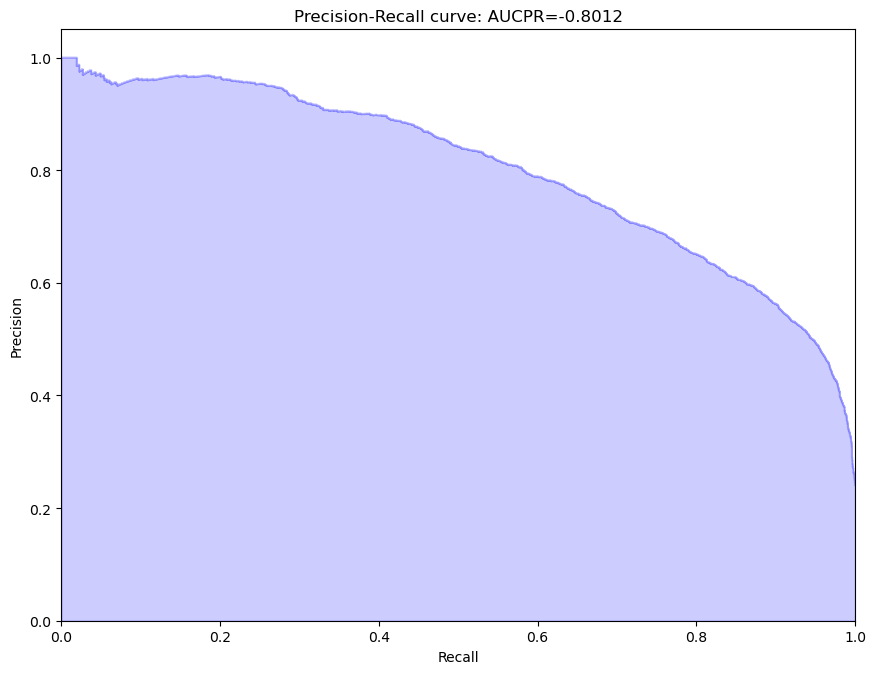

In [51]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_true = result["Target"].astype(int).values
y_score = result["P1"].values

precision, recall, thresholds = precision_recall_curve(y_true, y_score)
auc_pr = np.trapz(precision, recall)

plt.tight_layout()
plt.gcf().set_size_inches(10.24, 7.68)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AUCPR={0:0.4f}'.format(auc_pr))
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_true = result["Target"].astype(int).values
y_score = result["P1"].values

fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc_roc = auc(fpr, tpr)

plt.tight_layout()
plt.gcf().set_size_inches(10.24, 7.68)
plt.plot(fpr, tpr, color='b', lw=2, alpha=0.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
plt.xlabel('False Positive Rate - ' + var_model_name_full)
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Receiver Operating Characteristic curve: AUC={0:0.4f}'.format(auc_roc))
plt.savefig(var_path_model + var_model_name_full + "_auc_plot.png")
plt.show()